<a href="https://colab.research.google.com/github/TobyChen320/DS-Unit-2-Linear-Models/blob/master/Toby_Chen_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
df

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,Other,8/27/2019,NaN,NaN,NaN,6.00,1.0,NaN,NaN,17.0,20.5,0.57,5.0,4.0,3.5,NaN,4.0,4.0,2.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
419,Other,8/27/2019,NaN,NaN,NaN,6.00,4.0,NaN,NaN,19.0,26.0,1.02,4.0,5.0,NaN,3.5,4.0,4.0,5.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
420,California,8/27/2019,NaN,NaN,NaN,7.90,3.0,NaN,NaN,20.0,22.0,0.77,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
421,Other,8/27/2019,NaN,NaN,NaN,7.90,3.0,NaN,NaN,22.5,24.5,1.07,5.0,2.0,5.0,5.0,5.0,2.0,5.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
df['Date']=pd.to_datetime(df['Date'])
train=df[df['Date'].dt.year<=2016]
train

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,California,2016-12-02,4.0,4.3,NaN,5.65,3.0,NaN,NaN,19.5,22.0,0.75,4.0,1.5,2.0,3.0,4.2,4.0,3.0,2.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
297,Other,2016-12-02,NaN,NaN,NaN,5.49,3.0,NaN,NaN,19.0,20.5,0.64,4.5,5.0,2.0,2.0,2.5,3.5,3.0,2.5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
298,California,2016-12-10,3.5,3.7,NaN,7.75,4.0,NaN,NaN,20.0,21.0,0.70,3.5,2.5,3.0,3.3,1.4,2.3,2.2,3.3,4.5,NaN,NaN,X,X,NaN,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
299,Asada,2016-12-10,NaN,NaN,NaN,7.75,4.0,NaN,NaN,19.5,21.0,0.68,4.0,4.5,2.0,2.0,3.5,3.5,2.0,2.0,4.0,NaN,NaN,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [0]:
val=df[df['Date'].dt.year==2017]
val

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
301,California,2017-01-04,NaN,NaN,NaN,6.60,NaN,NaN,NaN,23.0,20.5,0.77,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.50,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
302,Other,2017-01-04,NaN,NaN,NaN,6.60,NaN,NaN,NaN,20.5,21.5,0.75,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
303,Other,2017-01-07,NaN,NaN,NaN,8.50,3.9,NaN,NaN,21.0,21.0,0.74,3.0,4.5,4.1,3.0,3.7,4.0,4.3,4.20,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
304,Other,2017-01-07,NaN,NaN,NaN,7.90,4.0,NaN,NaN,20.5,21.0,0.72,3.5,4.0,4.0,3.0,4.0,4.5,4.0,3.80,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
305,Other,2017-01-10,NaN,NaN,NaN,4.99,3.5,NaN,NaN,18.5,22.5,0.75,2.5,4.5,3.0,2.5,3.0,3.0,2.0,2.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,California,2017-09-05,NaN,NaN,NaN,6.85,3.5,NaN,NaN,22.5,22.5,0.91,3.0,4.5,3.8,3.8,4.0,3.5,3.5,4.00,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
382,California,2017-09-05,NaN,NaN,NaN,6.85,3.5,NaN,NaN,22.2,22.5,0.89,3.0,4.5,4.0,4.0,4.5,3.0,4.0,4.00,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
383,Other,2017-12-16,4.0,4.5,Yes,11.50,3.5,NaN,NaN,15.0,25.0,0.75,2.0,2.0,4.0,3.5,3.0,4.5,3.5,4.00,2.0,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
384,California,2017-12-29,NaN,NaN,NaN,7.89,4.0,NaN,NaN,19.0,23.0,0.80,4.0,3.0,4.0,4.0,3.0,4.0,3.5,4.30,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
test=df[df['Date'].dt.year>=2018]
test

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
77,California,2026-04-25,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
386,California,2018-01-02,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
387,Other,2018-01-09,4.5,3.8,NaN,4.19,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,2.0,2.0,4.0,1.0,4.0,3.0,4.0,x,NaN,NaN,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,False
388,California,2018-01-12,3.5,4.3,NaN,7.00,5.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
389,Other,2018-01-12,NaN,NaN,NaN,8.50,4.0,NaN,NaN,21.00,23.5,0.92,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
390,Asada,2018-04-04,NaN,NaN,NaN,7.20,3.0,NaN,NaN,24.50,22.7,1.00,4.0,5.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
391,Carnitas,2018-04-09,NaN,NaN,NaN,5.99,3.0,NaN,NaN,20.00,23.0,0.84,3.5,5.0,4.3,3.5,5.0,4.0,3.0,3.8,2.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
392,Carnitas,2018-04-09,NaN,NaN,NaN,5.99,3.5,NaN,NaN,17.50,24.0,0.80,4.0,4.5,5.0,4.5,5.0,4.0,4.0,4.5,4.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
393,Carnitas,2018-04-09,NaN,NaN,NaN,5.99,2.0,NaN,NaN,19.00,24.5,0.91,2.0,3.5,4.5,4.0,4.0,2.0,3.0,4.0,2.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
394,California,2018-04-14,NaN,NaN,NaN,8.99,4.0,NaN,NaN,25.00,23.0,1.05,4.5,4.5,4.0,4.0,3.0,4.0,3.5,4.0,3.0,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
train.shape, val.shape, test.shape

((298, 59), (85, 59), (38, 59))

In [0]:
target='Great'
y_train=train[target]
majority=y_train.mode()
y_train_pred=[majority]*len(y_train)
y_train_pred

[0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool, 0    False
 dtype: bool,

In [0]:
from sklearn.metrics import accuracy_score, mean_absolute_error
accuracy_score(y_train, y_train_pred)

0.5906040268456376

In [0]:
y_val=val[target]
y_pred=[majority]*len(val)
accuracy_score(y_val, y_pred)

0.5529411764705883

In [0]:
train.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,71.000000,71.000000,292.000000,297.000000,0.0,0.0,175.000000,174.000000,174.000000,298.000000,283.000000,288.000000,297.000000,292.000000,296.000000,278.000000,296.000000,296.000000,0.0
mean,3.897183,4.142254,6.896781,3.445286,NaN,NaN,19.829886,22.042241,0.770920,3.472315,3.706360,3.551215,3.519024,3.528870,3.395946,3.324640,3.540203,3.955068,NaN
std,0.478680,0.371738,1.211412,0.852150,NaN,NaN,2.081275,1.685043,0.137833,0.797606,0.991897,0.869483,0.850348,1.040457,1.089044,0.971226,0.922426,1.167341,NaN
min,2.500000,2.900000,2.990000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,NaN,NaN,18.500000,21.000000,0.662500,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,NaN
50%,4.000000,4.200000,6.850000,3.500000,NaN,NaN,19.500000,22.000000,0.750000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,3.750000,4.000000,NaN
75%,4.000000,4.400000,7.500000,4.000000,NaN,NaN,21.000000,23.000000,0.870000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,4.900000,11.950000,5.000000,NaN,NaN,26.000000,27.000000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
linear_reg = LinearRegression()
features = ['Yelp', 'Google',	'Cost',	'Hunger', 'Length',	'Circum',	'Volume',	'Tortilla',	'Temp',	'Meat',	'Fillings',	'Meat:filling',	'Uniformity',	'Salsa',	'Synergy',	'Wrap']
X_train = train[features]
X_val = val[features]
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
linear_reg.fit(X_train_imputed, y_train)
linear_reg.predict(X_val_imputed)

array([ 0.53160422,  0.49639941,  0.66055462,  0.59571679, -0.12212491,
        0.13538657,  0.83359786,  0.49877043, -0.02481807,  0.77643143,
        0.75694877, -0.05553553,  0.28293718,  0.31358049,  1.03604807,
        0.41605914,  0.40906669,  0.64362603,  0.63899424,  1.11097651,
        0.63493382,  0.47753632,  0.1188471 ,  0.54810157,  0.65757879,
        0.68587925,  0.70437383,  0.42792166,  0.48334497,  0.68371865,
        0.7611789 ,  0.47186949,  0.3721218 ,  0.39950396, -0.09902347,
       -0.01878977,  0.42972242,  0.57873428,  0.40398879,  0.50102965,
        0.41968988,  0.43513575,  0.47879177,  0.60973024,  0.61424744,
        0.4568679 ,  0.16016893,  0.19973556,  0.66299179, -0.19781305,
        0.22785082,  0.45941645,  0.84638977,  0.76738021,  0.43725022,
        0.16614088,  0.2230091 ,  0.18621903,  0.38512429,  0.38367767,
       -0.44962382,  0.33373709, -0.08414513,  0.47801874,  0.49522269,
        0.84514189,  0.56011928,  0.98405841,  0.5797118 ,  0.40

In [0]:
pd.Series(linear_reg.coef_, features)

Yelp            0.110046
Google         -0.131944
Cost            0.039942
Hunger          0.010213
Length          0.106009
Circum          0.181498
Volume         -2.681550
Tortilla        0.058383
Temp            0.051957
Meat            0.098342
Fillings        0.095065
Meat:filling    0.066059
Uniformity      0.016050
Salsa           0.033282
Synergy         0.131410
Wrap            0.005968
dtype: float64

In [0]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train_imputed, y_train)
y_pred = log_reg.predict(X_val_imputed)
print(f'Validation accuracy: {accuracy_score(y_val, y_pred)}')

Validation accuracy: 0.8235294117647058


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
log_reg.predict(X_val_imputed)

array([False, False,  True,  True, False, False,  True, False, False,
        True,  True, False, False, False,  True, False, False,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
       False, False,  True,  True, False, False,  True, False, False,
        True,  True, False, False, False,  True, False,  True,  True,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True, False,  True,  True])

In [0]:
log_reg.coef_

array([[ 1.79710014e-04, -1.57219640e+00,  2.01318113e-01,
         1.03123980e-01, -2.19245539e-01, -4.49997092e-01,
         1.57182263e+00,  5.73946380e-01,  3.25829976e-01,
         1.11161482e+00,  9.58278844e-01,  9.04949469e-01,
        -1.22955903e-02,  4.14216472e-01,  1.49935231e+00,
         5.10509953e-02]])

In [0]:
log_reg.intercept_

array([-3.81167906])

In [0]:
import category_encoders as ce 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)
X_train_enc.shape

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(298, 16)

In [0]:
X_train_enc

,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,3.5,4.2,6.49,3.0,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0
1,3.5,3.3,5.45,3.5,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0
2,NaN,NaN,4.85,1.5,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0
3,NaN,NaN,5.25,2.0,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0
4,4.0,3.8,6.59,4.0,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,4.0,4.3,5.65,3.0,19.5,22.0,0.75,4.0,1.5,2.0,3.0,4.2,4.0,3.0,2.0,4.5
297,NaN,NaN,5.49,3.0,19.0,20.5,0.64,4.5,5.0,2.0,2.0,2.5,3.5,3.0,2.5,3.0
298,3.5,3.7,7.75,4.0,20.0,21.0,0.70,3.5,2.5,3.0,3.3,1.4,2.3,2.2,3.3,4.5
299,NaN,NaN,7.75,4.0,19.5,21.0,0.68,4.0,4.5,2.0,2.0,3.5,3.5,2.0,2.0,4.0


In [0]:
X_train_imputed = imputer.fit_transform(X_train_enc)
X_val_imputed = imputer.transform(X_val_enc)
X_train_imputed.shape

(298, 16)

In [0]:
scaler=StandardScaler()
X_train_sc=scaler.fit_transform(X_train_imputed)
X_val_sc=scaler.transform(X_val_imputed)
X_train_sc=pd.DataFrame(X_train_sc, columns=X_train_enc.columns)
X_val_sc=pd.DataFrame(X_val_sc, columns=X_val_enc.columns)
X_train_sc

,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,-1.712002e+00,3.205145e-01,-0.339805,-0.524307,0.000000,0.000000,0.000000,-0.593162,1.340696,-0.645992,-0.022447,0.458224,0.557478,0.721245,0.500993,0.038686
1,-1.712002e+00,-4.674821e+00,-1.208571,0.064423,0.000000,0.000000,0.000000,-1.849023,-0.213867,-1.231964,-1.202403,-1.486989,0.557478,0.187274,-1.133401,0.899679
2,1.914185e-15,-4.929721e-15,-1.709783,-2.290496,0.000000,0.000000,0.000000,-0.593162,-1.768429,-1.231964,-0.612425,0.944528,0.557478,-0.346697,-0.588603,0.899679
3,1.914185e-15,-4.929721e-15,-1.375642,-1.701766,0.000000,0.000000,0.000000,-0.593162,-1.768429,-0.060021,-0.612425,0.458224,1.480371,0.721245,0.500993,0.899679
4,4.431779e-01,-1.899635e+00,-0.256270,0.653153,0.000000,0.000000,0.000000,0.662698,1.340696,0.525950,-0.022447,0.944528,1.480371,-0.880668,1.045791,0.038686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,4.431779e-01,8.755518e-01,-1.041501,-0.524307,-0.207428,-0.032901,-0.199197,0.662698,-2.286617,-1.817935,-0.612425,0.652746,0.557478,-0.346697,-1.678199,0.469183
294,1.914185e-15,-4.929721e-15,-1.175157,-0.524307,-0.521822,-1.201231,-1.246625,1.290629,1.340696,-1.817935,-1.792381,-1.000686,0.096031,-0.346697,-1.133401,-0.822306
295,-1.712002e+00,-2.454672e+00,0.712738,0.653153,0.106966,-0.811788,-0.675301,0.034768,-1.250242,-0.645992,-0.258438,-2.070553,-1.011441,-1.201051,-0.261724,0.469183
296,1.914185e-15,-4.929721e-15,0.712738,0.653153,-0.207428,-0.811788,-0.865742,0.662698,0.822508,-1.817935,-1.792381,-0.028079,0.096031,-1.414639,-1.678199,0.038686


In [0]:
model=LogisticRegressionCV()
model.fit(X_train_sc, y_train)
y_pred=model.predict(X_val_sc)
print(f'Validation accuracy: {accuracy_score(y_val, y_pred)}')

Validation accuracy: 0.8823529411764706


In [0]:
coefs=model.coef_[0]
coefs=pd.Series(coefs, X_train_sc.columns)
coefs

Yelp            0.093854
Google         -0.004266
Cost            0.195676
Hunger          0.119757
Length          0.042483
Circum          0.000300
Volume         -0.002146
Tortilla        0.309644
Temp            0.284428
Meat            0.577196
Fillings        0.579293
Meat:filling    0.492726
Uniformity      0.165661
Salsa           0.257620
Synergy         0.685466
Wrap            0.102378
dtype: float64

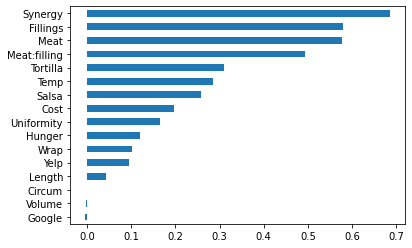

In [0]:
coefs.sort_values().plot.barh();